## Stacked LSTM practice

In this practice assignment, I will be building a stacked LSTM model using dampen *sine waves*

So what exactly is a *dampened sine wave* ? This is a type of sine wave whose amplitude decreases with time. The decrease in amplitude provides an additional longer term movement that may require an addtional level of abstraction in the LSTM model to learn. I can quickly show this using a simple python implementation.

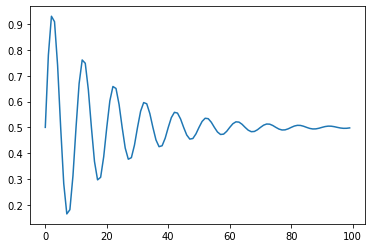

In [16]:
from math import sin
from math import pi
from math import exp
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# create sequence
length = 100
period = 10
decay = 0.05
sequence = [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]

#Plotting the sequence
plt.plot(sequence)
plt.show()

Next, we can create sequences of damped sine waves with different periods and decay values, withold the last few points of the series, and have the model predict them. First, we can define a function to generate a damped sine curve call **generate_sequence()**

In [17]:
# generate damped sine wave in [0,1]
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]

In [18]:
from random import randint
from random import uniform
import numpy as np

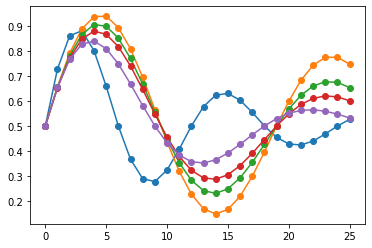

In [19]:
# generate input and output pairs of 5 different damped sine waves
def generate_examples(length, n_patterns, output):
    X, y = list(), list()
    for _ in range(n_patterns):
        p = randint(10,20)
        d = uniform(0.01,0.1)
        sequence = generate_sequence(length + output, p, d)
        X.append(sequence[:-output])
        y.append(sequence[-output:])
    X = np.array(X).reshape(n_patterns,length,1)
    y = np.array(y).reshape(n_patterns,output)
    return X, y

#Test problem generation
X, y = generate_examples(20,5,6)
for i in range(len(X)):
    plt.plot([x for x in X[i,:,0]] + [x for x in y[i]],'-o')

plt.show()

We can now fit the model on a dataset of randomly generated examples of damped sine waves. The model is expected to generalize a solution to predicting the last few time steps of a damped sine wave time series. 

So what we can do here is to generate a large number of random examples and fit the model on one epoch of this dataset. It would require more memory, but it may offer faster training and a more generalized solution. This is the approach we will use.

We will generate 10,000 random damped sine waves examples to fit the model using one epoch of this dataset. This is like fitting the model for 10,000 epochs. Ideally, we would reset the internal state of the model after each sample by setting the *batch size* to 1. In this case, we will trade off purity for training speed and set the *batch size* to 10. This will mean that the model weights will be updated and the LSTM memory cell internal state will be reset after each 10 samples.

In [20]:
# configure problem
length = 50
output = 6
# define model
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1))) 
model.add(LSTM(20))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit model
X, y = generate_examples(length, 10000, output)
history = model.fit(X, y, batch_size=10, epochs=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 20)            1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
Total params: 5,166
Trainable params: 5,166
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
10000/10000 [==============================] - 40s 4ms/step - loss: 0.0457


Once the model is fit, we can evaluate it. Here, we generate a new set of 1,000 random sequences and report the Mean Absolute Error (MAE). Evaluating the model report the MAE hovering at around 0.02 - 0.03 MAE range which is pretty reasonable. However, note that the specific MAE score may vary when you run it each time because of the stochastic nature of neural networks.

In [21]:
# evaluate model
X, y = generate_examples(length, 1000, output) 
loss = model.evaluate(X, y, verbose=0)
print('MAE: %f' % loss)

MAE: 0.027026


Next, we will try to make some predictions with the model. We can get a better idea of how skillful the model is by generating a standalone prediction and plotting it against expected output sequence. We can then call the *generate_examples()* function and generate one example and then make a prediction using the fit model. 

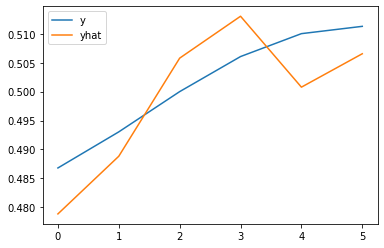

In [30]:
# prediction on new data
X, y = generate_examples(length, 1, output) 
yhat = model.predict(X, verbose=0) 
plt.plot(y[0], label='y') 
plt.plot(yhat[0], label='yhat') 
plt.legend()
plt.show()